In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) 
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [4]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, IterableDataset, DataLoader
from matplotlib import pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models


class FishDatasetLoader:
    def __init__(self, train_images_path) -> None:
        self.train_images_path = train_images_path

    def getData(self):
        print("creating loader...")
        valid_size = 0.2

        _transforms = transforms.Compose([
            transforms.Resize((224, 224)), 
            transforms.RandomEqualize(1),
            transforms.ToTensor(), 
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std = [0.25, 0.25, 0.25]
            )

            ]) #resizes to square idk if good

        train_data = datasets.ImageFolder(self.train_images_path, transform=_transforms)
        test_data = datasets.ImageFolder(self.train_images_path, transform=_transforms)

        #getting test images randomly selected from train ones
        num_train = len(train_data)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))
        np.random.shuffle(indices)
        from torch.utils.data.sampler import SubsetRandomSampler
        train_idx, test_idx = indices[split:], indices[:split]
        
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(test_idx)

        trainloader = torch.utils.data.DataLoader(train_data,
                    sampler=train_sampler, batch_size=64)
        testloader = torch.utils.data.DataLoader(test_data,
                    sampler=test_sampler, batch_size=64)

        return trainloader, testloader

    
    def getModel(self):
        print("creating model...")
        print(torch.cuda.is_available())
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        #model = models.resnet50(pretrained=False)
        # print(model)

        
        model = VGG16()


        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        model.to(device)
        return model, device, optimizer, criterion
    
    # for now there is no testset (testset = trainset)
    def trainModel(self, model, trainloader, testloader, device, optimizer, criterion):
        print("training...")

        epochs = 5
        steps = 0
        running_loss = 0
        print_every = 1
        train_losses, test_losses, accuracies = [], [], []


        for epoch in range(epochs):
            torch.cuda.empty_cache()
            for inputs, labels in trainloader:
                steps += 1
                
                if torch.cuda.is_available():
                  inputs, labels = inputs.cuda(), labels.cuda()
                else:
                  inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                logps = model.forward(inputs)
                loss = criterion(logps, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                if steps % print_every == 0:

                    test_loss = 0
                    accuracy = 0
                    model.eval()
                    with torch.no_grad():
                        for inputs, labels in testloader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            logps = model.forward(inputs)
                            batch_loss = criterion(logps, labels)
                            test_loss += batch_loss.item()
                            
                            ps = torch.exp(logps)
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels.view(*top_class.shape)
                            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                    train_losses.append(running_loss)
                    test_losses.append(test_loss/len(testloader))    
                    accuracies.append(accuracy/len(testloader))                
                    print(f"Epoch {epoch+1}/{epochs}.. "
                        f"Train loss: {running_loss/print_every:.3f}.. "
                        f"Test loss: {test_loss/len(testloader):.3f}.. "
                        f"Test accuracy: {accuracy/len(testloader):.3f}")
                    running_loss = 0
                    model.train()

        torch.save(model, 'aerialmodel.pth')
        return train_losses, test_losses, accuracies
    
    def check_work(self, train_losses, test_losses, accuracies):
        plt.figure(0)
        plt.plot(train_losses, label='Training loss')
        plt.plot(test_losses, label='Validation loss')
        plt.legend(frameon=False)

        plt.figure(1)
        plt.plot(accuracies, label='Accuraccy')
        plt.show()



    def doWork(self):
        trainloader, testloader = self.getData()
        model, device, optimizer, criterion = self.getModel()
        train_losses, test_losses, accuracies = self.trainModel(model, trainloader, testloader, device, optimizer, criterion)
        self.check_work(train_losses, test_losses, accuracies)

creating loader...
creating model...
True
training...
Epoch 1/5.. Train loss: 2.298.. Test loss: 2.272.. Test accuracy: 0.471
Epoch 1/5.. Train loss: 2.266.. Test loss: 2.232.. Test accuracy: 0.470
Epoch 1/5.. Train loss: 2.220.. Test loss: 2.157.. Test accuracy: 0.470
Epoch 1/5.. Train loss: 2.166.. Test loss: 2.015.. Test accuracy: 0.469
Epoch 1/5.. Train loss: 2.018.. Test loss: 1.786.. Test accuracy: 0.471
Epoch 1/5.. Train loss: 1.846.. Test loss: 2.064.. Test accuracy: 0.469
Epoch 1/5.. Train loss: 2.434.. Test loss: 1.712.. Test accuracy: 0.468
Epoch 1/5.. Train loss: 1.505.. Test loss: 1.706.. Test accuracy: 0.470
Epoch 1/5.. Train loss: 1.643.. Test loss: 1.736.. Test accuracy: 0.469
Epoch 1/5.. Train loss: 1.797.. Test loss: 1.748.. Test accuracy: 0.470
Epoch 1/5.. Train loss: 1.798.. Test loss: 1.741.. Test accuracy: 0.469
Epoch 1/5.. Train loss: 1.630.. Test loss: 1.713.. Test accuracy: 0.469
Epoch 1/5.. Train loss: 1.923.. Test loss: 1.675.. Test accuracy: 0.471
Epoch 1/5.

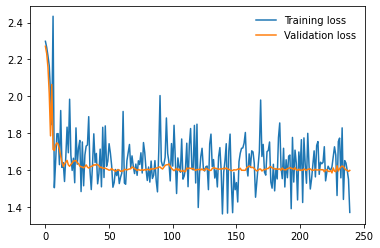

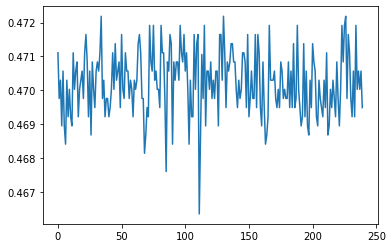

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor

def getMasterFolderPath():
    fileStream = open("/content/drive/MyDrive/path.txt", "r")
    return fileStream.read()

def dataUpload():
    master_folder_path = getMasterFolderPath()
    train_images_path = master_folder_path + "/train"

    fish_loader = FishDatasetLoader(train_images_path)
    fish_loader.doWork()


def main():
    torch.cuda.empty_cache()
    dataUpload()

main()